In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from gstatsmcmc import Topography
from gstatsmcmc import MCMC_test
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
import config

# data viz
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from scipy.ndimage import gaussian_filter, binary_erosion
import timeit


In [2]:
df = pd.read_csv('../data//BindSchalder_Macayeal_IceStreams.csv')
df

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
0,-997250,-1056750,1995.0,NaN,3.154910,3.089999,0.188461,0.015527,False,1.0,1995.0,5.0,2013.206726,-68.0
1,-996750,-1056750,1991.0,NaN,2.865254,2.668077,0.187869,0.015527,False,1.0,1991.0,5.0,2003.393005,-65.0
2,-996250,-1056750,1989.0,NaN,3.341836,3.024601,0.187278,0.015527,False,1.0,1989.0,5.0,1992.894836,-60.0
3,-995750,-1056750,1988.0,NaN,3.897542,3.608380,0.186686,0.015527,False,1.0,1988.0,5.0,1983.685974,-54.0
4,-995250,-1056750,1987.0,NaN,3.632191,3.761807,0.186094,0.014805,False,1.0,1987.0,5.0,1974.599670,-49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193309,-410750,-550750,312.0,NaN,515.422234,-264.242581,0.067617,0.199329,True,1.0,312.0,5.0,943.046890,-654.0
1193310,-410250,-550750,311.0,NaN,517.782817,-260.324541,0.067526,0.200631,True,1.0,311.0,5.0,941.342056,-648.0
1193311,-409750,-550750,311.0,NaN,520.233378,-256.053416,0.067435,0.201009,True,1.0,311.0,5.0,940.834976,-642.0
1193312,-409250,-550750,311.0,NaN,522.270657,-252.067006,0.067344,0.199707,True,1.0,311.0,5.0,939.315460,-637.0


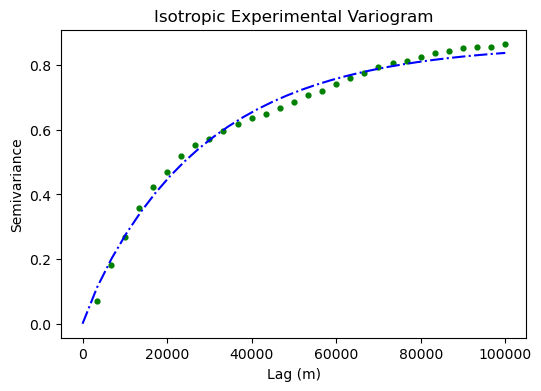

In [3]:
test_x = df.x[:735000]
test_y = df.y[:850000]
# (-735000, -850000)
x_test, y_test = np.unique(test_x), np.unique(test_y)
cropX1, cropY1 = np.meshgrid(x_test, y_test)
cropX1.shape, cropY1.shape

# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

bedmachine_bed = bedmap_surf - bedmachine_thickness

# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.10, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [4]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('../sgs_bed_bindshalder.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

grounded_ice_mask = (bedmap_mask == 1)
largeScaleChain = MCMC_test.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)
largeScaleChain.grounded_ice_mask[-1,-1]
largeScaleChain.set_update_region(True,highvel_mask) 
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)
the update blocks is set to be randomly generated for any locations inside the given region


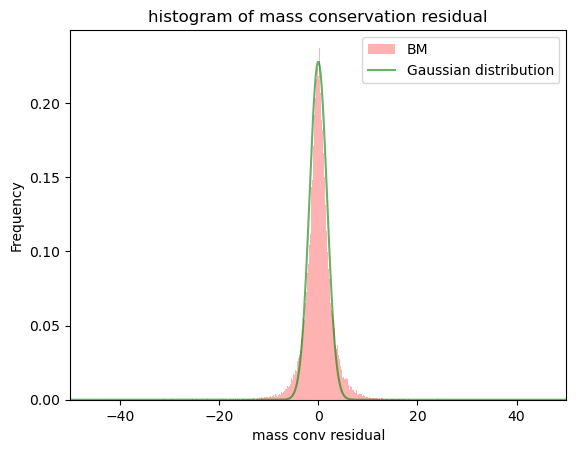

In [5]:
sigma3 = config.sigma3
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

In [6]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=config.sigma3, massConvInRegion=True)
largeScaleChain.loss(mc_res_bm, 0)
#range_max and range_min changes topographies features' lateral scale
#by default, I set range_max to variogram range
range_max_x = V1_p[0] #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = V1_p[0]
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 150
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC_test.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)
rf1.set_generation_method(spectral=True)
min_block_x = 50
max_block_x = 80
min_block_y = 50
max_block_y = 80
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)
largeScaleChain.crf_data_weight = np.loadtxt('../data_weight.txt',dtype=np.float64) 
largeScaleChain.set_update_type('CRF_weight')
seed = 20251019
rng = np.random.default_rng(seed)
# Load our previous bed 
NUMBER_OF_ITERATIONS = 20000
index_we_want_compare = 145
last_iterated_bed = np.loadtxt(f'../{index_we_want_compare}final_bed_largeCRF.txt')    


largeScaleChain.initial_bed = last_iterated_bed


print(index_we_want_compare)


Before using the `RandField` object in an MCMC chain or for field generation, 
 call function `set_block_sizes` to initialize block size ranges; 
 call function `set_weight_param` to set up conditional weighting parameters; 
 call function 'set_generation_method' to set up method used to generate random fields.
The update block is set to conditional random field generated by calculating weights with logistic function
145


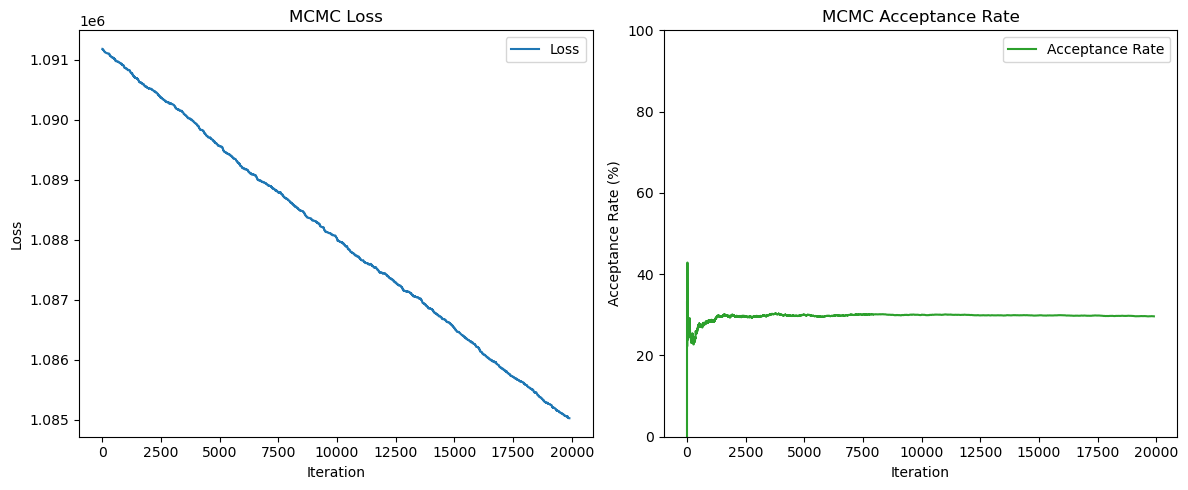

  0%|          | 0/19999 [00:00<?, ?it/s]

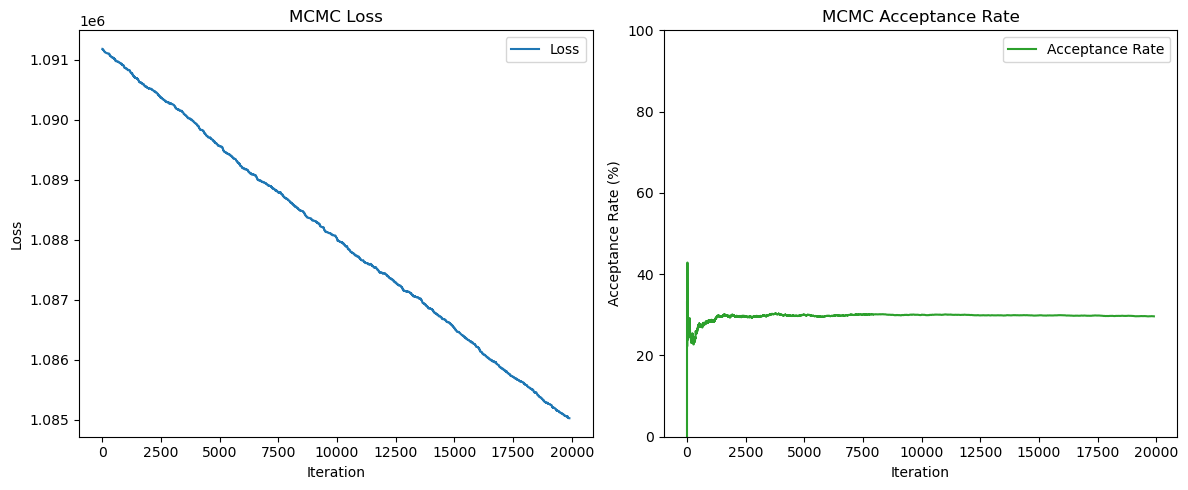

In [8]:
loc_current_beds, loc_loss_mc, loss_data, loc_loss, loc_steps, resampled_times, blocks_used, loc_rate_cache  = largeScaleChain.run_localblock(n_iter=NUMBER_OF_ITERATIONS, 
                                                                                                RF=rf1, 
                                                                                                rng_seed=rng, 
                                                                                                only_save_last_bed=True, 
                                                                                                info_per_iter = 100,
                                                                                                progress_bar=True,
                                                                                                plot=True)

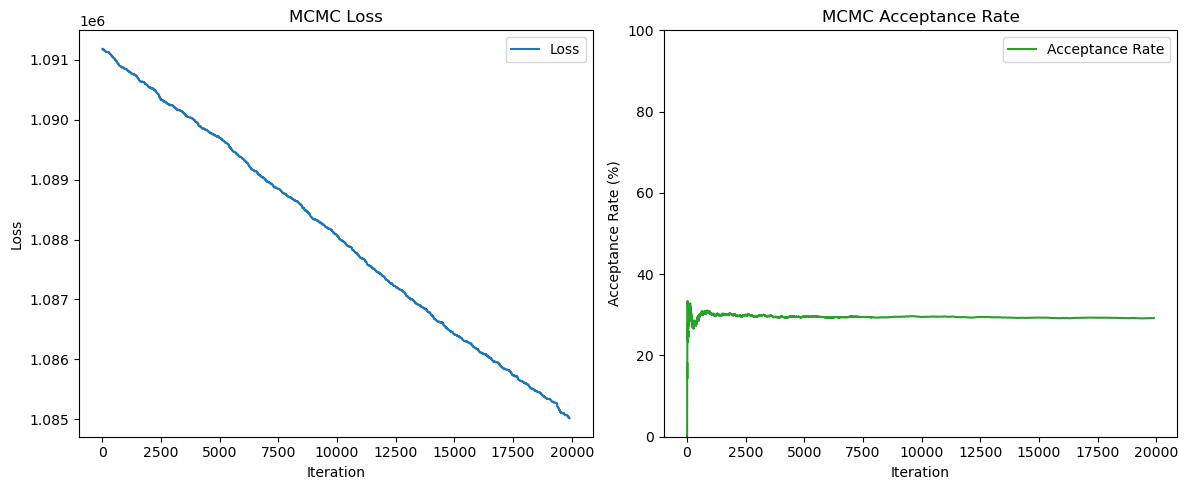

  0%|          | 0/19999 [00:00<?, ?it/s]

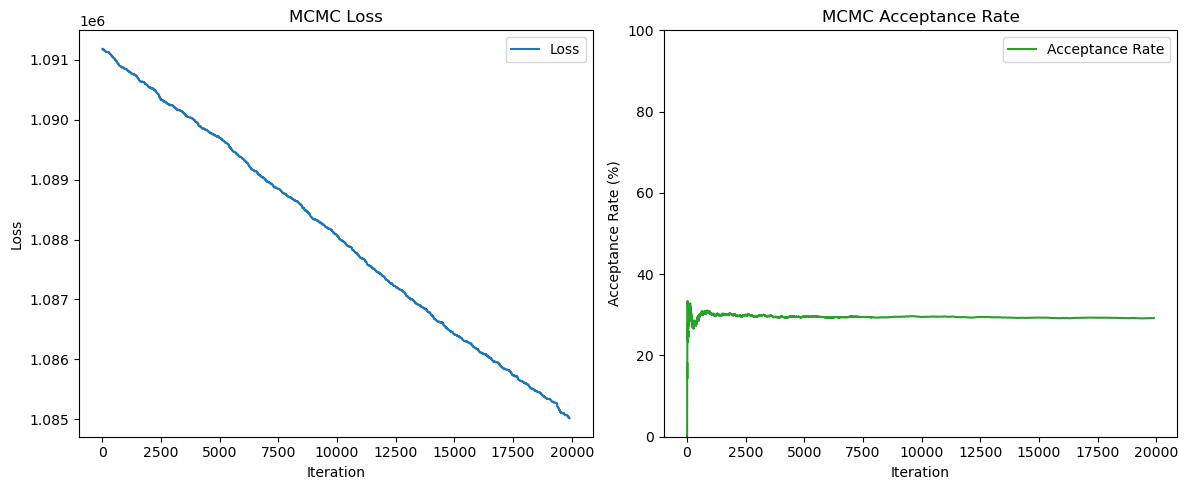

In [9]:
norm_current_beds, _, _, norm_loss, norm_steps, _, _, norm_rate_cache  = largeScaleChain.run_normal(n_iter=NUMBER_OF_ITERATIONS, 
                                                                                                RF=rf1, 
                                                                                                rng_seed=rng, 
                                                                                                only_save_last_bed=True, 
                                                                                                info_per_iter = 100,
                                                                                                progress_bar=True,
                                                                                                plot=True)

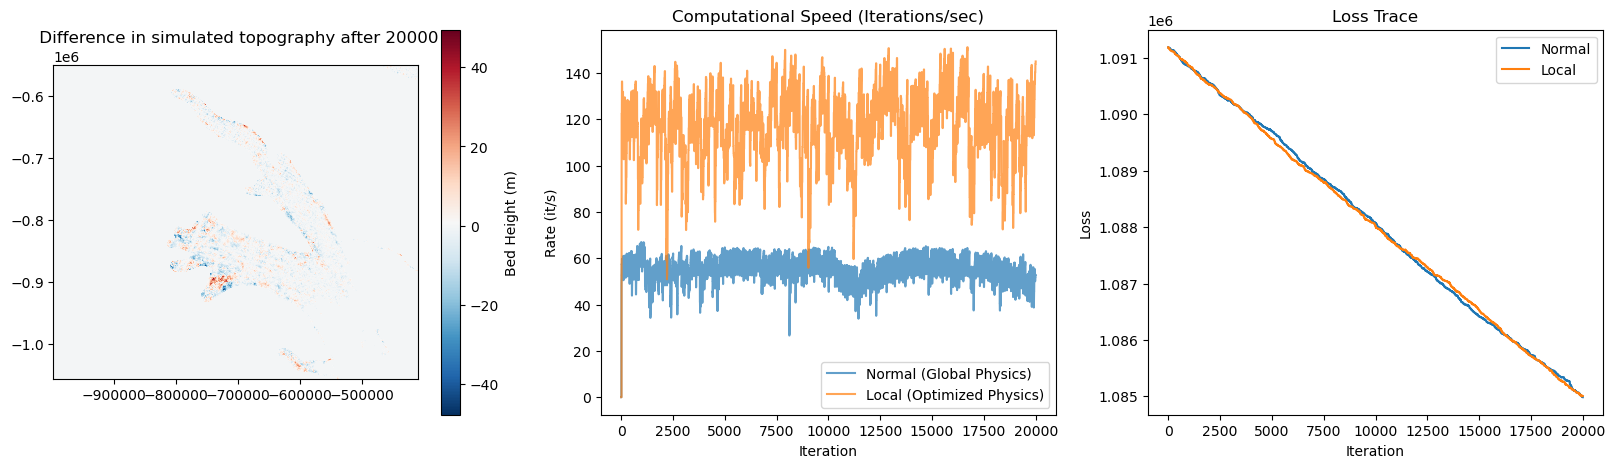

In [18]:
fig , axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
ax = axes[0]
diff = (norm_current_beds - loc_current_beds)
im1 = ax.pcolormesh(xx, yy, diff, cmap='RdBu_r' )
ax.axis('scaled')
cbar1 = fig.colorbar(im1, ax=ax)
cbar1.set_label('Bed Height (m)')
ax.set_title(f" Difference in simulated topography after {NUMBER_OF_ITERATIONS}")

ax = axes[1]
ax.plot(norm_rate_cache, label='Normal (Global Physics)', alpha=0.7)
ax.plot(loc_rate_cache, label='Local (Optimized Physics)', alpha=0.7)
ax.set_title("Computational Speed (Iterations/sec)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Rate (it/s)")
ax.legend()



ax = axes[2]
ax.plot(norm_loss, label='Normal')
ax.plot(loc_loss, label='Local')
ax.set_title("Loss Trace")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()



